# Financial PhraseBank Dataset Analysis

## Introduction

Perform an exploratory data analysis (EDA) on the Financial PhraseBank dataset to assess dataset quality, structure, and potential challenges for sentiment classification.
This includes class distribution analysis, sentence length analysis, duplicate/missing value detection, vocabulary exploration (n-grams), and linguistic properties (POS tags).

### Library Imports and Setup

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing libraries
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from scipy.stats import chisquare

### Data Loading

In [2]:
# Specify the file name containing sentences and their corresponding sentiment labels
filename = 'Sentences_AllAgree.txt'

# Initialize empty lists to store sentences and labels separately
sentences, labels = [], []

# Open the file with ISO-8859-1 encoding to handle special characters
with open(filename, 'r', encoding='iso-8859-1') as f:
    for line in f:
        # Check if the line contains the separator '@' indicating label presence
        if '@' in line:
            # Split the line at the last '@' into sentence and label
            sentence, label = line.strip().rsplit('@', 1)
            # Append the sentence and label to their respective lists
            sentences.append(sentence)
            labels.append(label)

# Create a pandas DataFrame from the extracted sentences and labels
df = pd.DataFrame({'sentence': sentences, 'label': labels})

# Output the total number of samples loaded
print(f"Loaded {len(df)} samples.")

# Display the first few rows to verify the loaded data
df.head()

Loaded 2264 samples.


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


### Basic Dataset Summary

In [3]:
# Class distribution
label_counts = df['label'].value_counts()
label_percent = df['label'].value_counts(normalize=True) * 100
summary_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percent.round(2)})

summary_df

,Count,Percentage
label,,
neutral,1391,61.44
positive,570,25.18
negative,303,13.38


The dataset consists of three sentiment classes (positive, negative, neutral) with a notable imbalance toward the neutral class.

### Visualize Sentiment Class Distribution

C:\Users\elias\AppData\Local\Temp\ipykernel_22992\3164424279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df['Count'], palette='pastel')
C:\Users\elias\AppData\Local\Temp\ipykernel_22992\3164424279.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value + 10, f"{value} ({summary_df['Percentage'][index]}%)", ha='center')


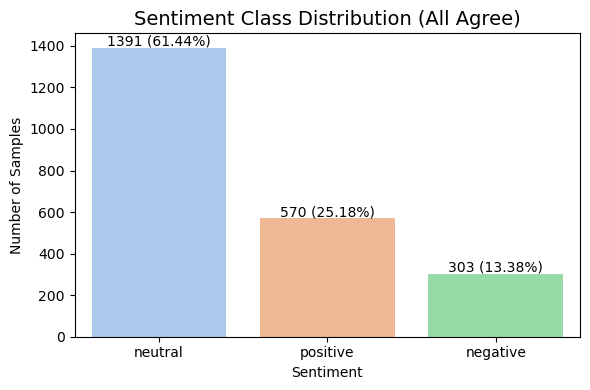

In [4]:
plt.figure(figsize=(6, 4))
sns.barplot(x=summary_df.index, y=summary_df['Count'], palette='pastel')
plt.title('Sentiment Class Distribution (All Agree)', fontsize=14)
plt.ylabel('Number of Samples')
plt.xlabel('Sentiment')
for index, value in enumerate(summary_df['Count']):
    plt.text(index, value + 10, f"{value} ({summary_df['Percentage'][index]}%)", ha='center')
plt.tight_layout()
plt.show()

### Check for Duplicates and Missing Values

In [5]:
print(f"Duplicate Sentences: {df.duplicated(subset='sentence').sum()}")
print("\nMissing values per column:")
print(df.isnull().sum())

Duplicate Sentences: 5

Missing values per column:
sentence    0
label       0
dtype: int64


In [6]:
# Drop duplicate sentences
df = df.drop_duplicates(subset='sentence').reset_index(drop=True)

print(f"After removing duplicates, the dataset now has {len(df)} samples.")

After removing duplicates, the dataset now has 2259 samples.


### Sentence Length Analysis

In [7]:
# Sentence lengths
df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))
df['char_count'] = df['sentence'].apply(len)

# Summary statistics
df[['word_count', 'char_count']].describe()

,word_count,char_count
count,2259.00000,2259.000000
mean,22.43382,121.880035
std,10.12125,56.032069
min,2.00000,9.000000
25%,15.00000,79.000000
50%,21.00000,111.000000
75%,28.00000,157.000000
max,81.00000,315.000000


### Visualize Sentence Length Distribution

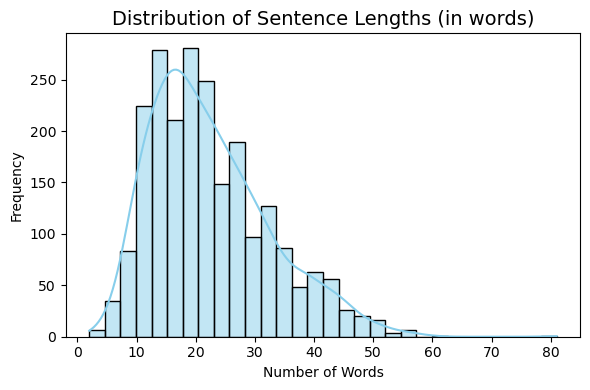

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths (in words)', fontsize=14)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Chi-Squared Test for Label Imbalance

In [9]:
# Count the number of occurrences for each label in the dataset
observed = df['label'].value_counts().values

# Create an expected distribution assuming a uniform distribution across 3 classes
expected = [len(df) / 3] * 3  # Each class expected to have equal frequency

# Perform a chi-square goodness-of-fit test to compare observed vs. expected frequencies
chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)

# Print the resulting Chi-square statistic and corresponding p-value
print(f"Chi2 statistic = {chi2_stat:.2f}, p-value = {p_val:.4f}")

Chi2 statistic = 845.52, p-value = 0.0000


A chi-squared test shows significant imbalance in label distribution (p < 0.05), justifying the use of macro-averaged metrics.

### Top N-Grams Analysis

In [10]:
# 🔹 Unigrams: Count single words (1-gram) after removing English stopwords
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english')  # Only unigrams, remove stopwords
X1 = vectorizer.fit_transform(df['sentence'])  # Transform sentences into unigram frequency matrix
unigram_freq = pd.DataFrame(X1.sum(axis=0), columns=vectorizer.get_feature_names_out()).T  # Sum frequencies
unigram_freq.columns = ['frequency']  # Rename column for clarity
unigram_freq.sort_values('frequency', ascending=False).head(10)  # Show top 10 most frequent unigrams

# 🔹 Bigrams: Count two-word combinations (2-gram) after removing English stopwords
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')  # Only bigrams, remove stopwords
X2 = vectorizer.fit_transform(df['sentence'])  # Transform sentences into bigram frequency matrix
bigram_freq = pd.DataFrame(X2.sum(axis=0), columns=vectorizer.get_feature_names_out()).T  # Sum frequencies
bigram_freq.columns = ['frequency']  # Rename column for clarity
bigram_freq.sort_values('frequency', ascending=False).head(10)  # Show top 10 most frequent bigrams

,frequency
eur mn,165
net sales,147
operating profit,145
mn eur,119
corresponding period,91
net profit,84
mln euro,76
profit eur,54
eur million,52
said today,50


### Part-of-Speech (POS) Tag Distribution

In [11]:
# 🔹 Load spaCy English language model for POS tagging
import spacy
nlp = spacy.load('en_core_web_sm')  # Load small English model

# 🔹 Perform Part-of-Speech (POS) tagging on all sentences
from collections import Counter
pos_counts = Counter()  # Initialize counter for POS tags

# Process sentences in batches for efficiency
for doc in nlp.pipe(df['sentence'], batch_size=500):
    pos_counts.update([token.pos_ for token in doc])  # Count POS tags in each sentence

# 🔹 Convert POS counts to DataFrame for visualization
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS', 'Count'])  # Convert to DataFrame
pos_df = pos_df.sort_values('Count', ascending=False)  # Sort by most frequent POS
pos_df  # Display the POS tag frequencies

,POS,Count
5,NOUN,11567
2,PROPN,7401
1,ADP,6473
3,PUNCT,5961
0,VERB,3961
11,NUM,3819
4,DET,3767
10,ADJ,3026
9,AUX,1715
13,CCONJ,1288


C:\Users\elias\AppData\Local\Temp\ipykernel_22992\3253495632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='POS', y='Count', data=pos_df, palette='muted')


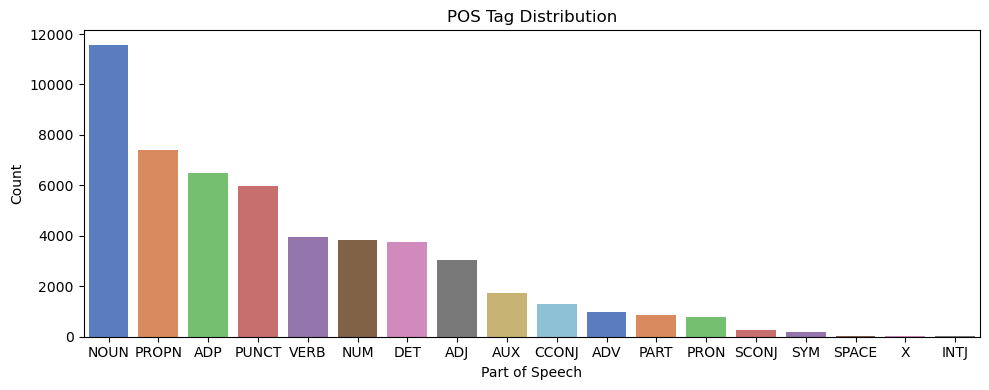

In [150]:
plt.figure(figsize=(10, 4))
sns.barplot(x='POS', y='Count', data=pos_df, palette='muted')
plt.title('POS Tag Distribution')
plt.xlabel('Part of Speech')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Sentence Length by Sentiment Class

C:\Users\elias\AppData\Local\Temp\ipykernel_22992\3374202633.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette='pastel')


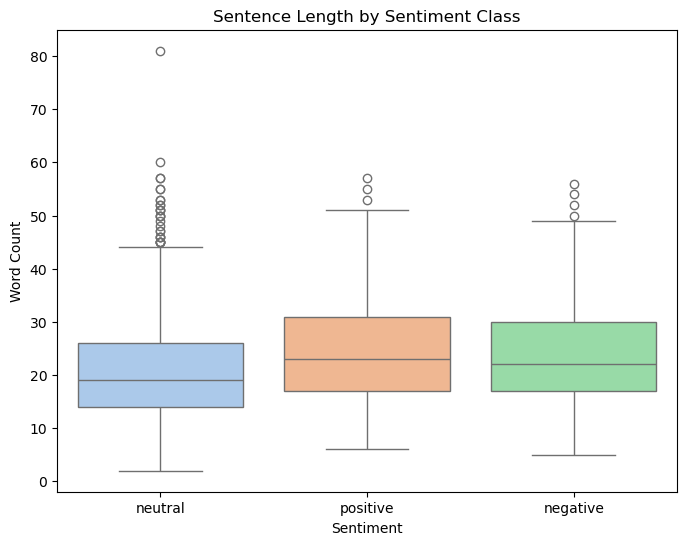

In [13]:
# 🔹 Create a boxplot to visualize sentence length distribution across sentiment classes
plt.figure(figsize=(8, 6))  # Set the size of the plot

# Create a boxplot using seaborn: x-axis = sentiment labels, y-axis = word count
sns.boxplot(x='label', y='word_count', data=df, palette='pastel')

# Add plot title and axis labels
plt.title('Sentence Length by Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')

# Display the plot
plt.show()

## Data Preprocessing and Feature Representation

To prepare the financial text data for classification, we apply several preprocessing strategies. For classical machine learning models, we explore combinations of:

- Lowercasing
- Removal of punctuation and digits
- Optional stopword removal
- Optional lemmatization

For vectorization, we apply:
- Bag-of-Words (BoW)
- TF-IDF
- Word2Vec embeddings (100-dim)
- Optional class balancing via SMOTE

These strategies are systematically tested to evaluate their individual and combined effect on model performance.

### Import Libraries

In [14]:
# Core imports
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.base import TransformerMixin, BaseEstimator

# Class balancing
from imblearn.over_sampling import SMOTE

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Preprocessing Functions

In [15]:
# 🔧 Setup: Load stopwords and lemmatizer from NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 🧹 Preprocessing function for classical ML models
def preprocess_text(text, remove_stopwords=True, apply_lemmatization=True):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespaces
    tokens = text.split()  # Tokenize sentence into words
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    if apply_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    return ' '.join(tokens)  # Rejoin tokens into a single string

# 🔄 Word2Vec wrapper class for use in sklearn pipelines
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        # Set model hyperparameters
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None  # Placeholder for trained Word2Vec model

    def fit(self, raw_documents, y=None):
        # Tokenize input documents
        tokenized = [doc.split() for doc in raw_documents]
        # Train Word2Vec model on tokenized sentences
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size, window=self.window,
                              min_count=self.min_count, workers=4, seed=42)
        return self

    def transform(self, raw_documents):
        X = []  # Initialize feature matrix
        for doc in raw_documents:
            tokens = doc.split()
            # Extract vectors for known tokens
            vectors = [self.model.wv[word] for word in tokens if word in self.model.wv]
            # Average the word vectors, or use zero vector if no known tokens
            if vectors:
                X.append(np.mean(vectors, axis=0))
            else:
                X.append(np.zeros(self.size))
        return np.array(X)  # Return 2D array of sentence embeddings

### Apply Preprocessing (Classical + FinBERT)

In [16]:
# Preprocess for classical ML models (default: remove stopwords + lemmatize)
df['clean_sentence'] = df['sentence'].apply(lambda x: preprocess_text(x, remove_stopwords=True, apply_lemmatization=True))

# Preprocess for FinBERT (minimal: just strip spaces)
df['finbert_sentence'] = df['sentence'].str.strip()

# View sample comparison
df[['sentence', 'clean_sentence', 'finbert_sentence']].sample(5, random_state=42)

,sentence,clean_sentence,finbert_sentence
1573,- The Group -¦ s sales during the period were ...,group sale period eur million eur million prof...,- The Group -¦ s sales during the period were ...
368,Profit after taxes for the period was up to EU...,profit tax period eur eur last year,Profit after taxes for the period was up to EU...
528,`` They want my credit card info and my person...,want credit card info personal detail,`` They want my credit card info and my person...
1530,The value of the orders is over EUR 10mn .,value order eur mn,The value of the orders is over EUR 10mn .
56,"In 2009 , Fiskars ' cash flow from operating a...",fiskars cash flow operating activity amounted ...,"In 2009 , Fiskars ' cash flow from operating a..."


### Feature Representation: BoW and TF-IDF

We extract two sparse vector representations:
- **BoW**: Simple term frequency using unigrams and bigrams
- **TF-IDF**: Term Frequency-Inverse Document Frequency with n-grams

These will be evaluated in combination with different preprocessing settings and classifiers.


In [17]:
# 📊 Bag-of-Words (BoW) Vectorization
# Convert text into sparse vectors using unigrams and bigrams (1-gram and 2-gram), with a max of 5000 features
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['clean_sentence'])

# 🧠 TF-IDF Vectorization
# Apply Term Frequency-Inverse Document Frequency on the cleaned text to weigh important terms
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_sentence'])

# 🏷️ Extract target labels for classification
y = df['label']

### Addressing Class Imbalance: SMOTE

The dataset shows class imbalance (neutral ≫ positive > negative).  
We apply **SMOTE (Synthetic Minority Over-sampling Technique)** only to the training set to balance the classes during model training.

In [18]:
from sklearn.model_selection import train_test_split

# 📦 Split the TF-IDF features and labels into training and test sets
# 20% of the data is held out for testing, and stratification maintains label proportions
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

# ⚖️ Apply SMOTE to balance class distribution in the training set
# SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic examples for minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 📊 Display the new balanced class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
label
positive    1109
neutral     1109
negative    1109
Name: count, dtype: int64


### WordCloud Visualizations

To understand the effect of preprocessing on the vocabulary distribution, we visualize the most frequent tokens using WordClouds from the raw and cleaned sentences.


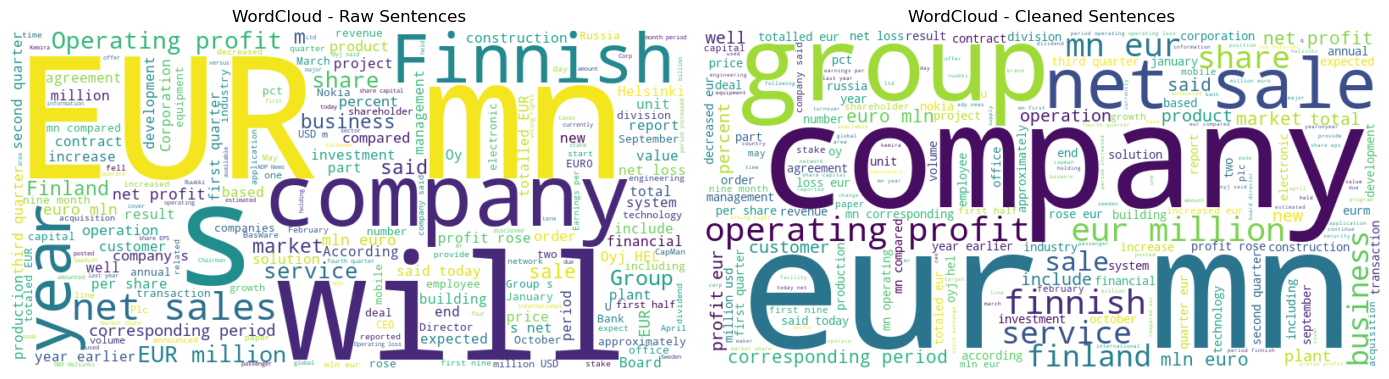

In [19]:
# ☁️ Generate WordCloud for raw text (before any preprocessing)
text_raw = ' '.join(df['sentence'])
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(text_raw)

# ☁️ Generate WordCloud for cleaned text (after preprocessing like lowercasing, lemmatization, etc.)
text_cleaned = ' '.join(df['clean_sentence'])
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='white').generate(text_cleaned)

# 📊 Plot both word clouds side by side for visual comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.title('WordCloud - Raw Sentences')
plt.axis('off')  # Hide axes

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.title('WordCloud - Cleaned Sentences')
plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Systematic Preprocessing Experiments

This section investigates how different combinations of preprocessing, vectorization techniques, and class balancing affect the performance of classical machine learning models (Logistic Regression and Linear SVM).

The experimental configurations include:
- **Preprocessing**: 
  - Basic Cleaning (lowercasing + punctuation removal)
  - Stopword Removal
  - Lemmatization
  - Both Stopword Removal + Lemmatization
- **Vectorization**: 
  - TF-IDF (unigram + bigram)
  - Bag-of-Words (BoW)
  - Word2Vec (100-dimensional mean embedding)
- **Balancing**: 
  - With and without SMOTE (Synthetic Minority Oversampling)

Each configuration is evaluated using macro-averaged metrics (Accuracy, Precision, Recall, F1) to account for class imbalance.


### Functions for Systematic Experiment

In [20]:
# 📦 Import required libraries for preprocessing, modeling, evaluation, and vectorization
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# 📦 Optional imports
from gensim.models import Word2Vec               # For Word2Vec vectorization
from imblearn.over_sampling import SMOTE         # For handling class imbalance

# 🧠 Load NLTK resources for stopword removal and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 🔧 Text preprocessing function
def preprocess_text(text, remove_stopwords=True, apply_lemmatization=True):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and digits
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    tokens = text.split()
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    if apply_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]      # Apply lemmatization
    return ' '.join(tokens)

# 🧬 Word2Vec Vectorizer: Scikit-learn compatible wrapper
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=1):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, raw_documents, y=None):
        tokenized = [doc.split() for doc in raw_documents]  # Tokenize input text
        self.model = Word2Vec(sentences=tokenized, vector_size=self.size, window=self.window,
                              min_count=self.min_count, workers=4, seed=42)
        return self

    def transform(self, raw_documents):
        X = []
        for doc in raw_documents:
            tokens = doc.split()
            vectors = [self.model.wv[word] for word in tokens if word in self.model.wv]  # Extract vectors for known words
            if vectors:
                X.append(np.mean(vectors, axis=0))  # Average word vectors for document
            else:
                X.append(np.zeros(self.size))       # If no known words, fill with zeros
        return np.array(X)

# 🧪 Main experiment runner function
def run_experiment(prep_name, vect_name, vectorizer, remove_stopwords, lemmatize, use_smote):
    # Preprocess text with selected options and save to a new column
    df[f"processed_{prep_name}"] = df['sentence'].apply(
        lambda x: preprocess_text(x, remove_stopwords, lemmatize)
    )

    # Define input (X) and target (y) variables
    X = df[f"processed_{prep_name}"]
    y = df['label']
    le = LabelEncoder()  # Encode string labels into integers
    y = le.fit_transform(y)

    # Split into train and test sets (stratified by label)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Vectorize train and test input using given vectorizer
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Optional: Apply SMOTE to balance training data
    if use_smote:
        sm = SMOTE(random_state=42)
        X_train_vec, y_train = sm.fit_resample(X_train_vec, y_train)

    results = []
    
    # Train and evaluate both models
    for model_name, model in [
        ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
        ('Linear SVM', LinearSVC(max_iter=5000, random_state=42))
    ]:
        model.fit(X_train_vec, y_train)  # Train
        y_pred = model.predict(X_test_vec)  # Predict
        results.append({
            'Preprocessing': prep_name,
            'Vectorizer': vect_name,
            'SMOTE': use_smote,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
            'F1': f1_score(y_test, y_pred, average='macro', zero_division=0)
        })

    return results

### Experiment Setup

In [21]:
# ✅ Define experiment settings for preprocessing and feature extraction

# 🔧 Preprocessing variants to test different combinations:
# - basic_cleaning: no stopword removal or lemmatization
# - stopword_removal: remove stopwords only
# - lemmatization_only: apply lemmatization only
# - stopwords_and_lemmatization: apply both stopword removal and lemmatization
preprocessing_variants = {
    "basic_cleaning": {"stopwords": False, "lemmatization": False},
    "stopword_removal": {"stopwords": True, "lemmatization": False},
    "lemmatization_only": {"stopwords": False, "lemmatization": True},
    "stopwords_and_lemmatization": {"stopwords": True, "lemmatization": True}
}

# 🧮 Vectorization techniques to compare
# - TF-IDF: Term frequency-inverse document frequency with unigrams + bigrams
# - BoW: Bag-of-Words representation with unigrams + bigrams
# - Word2Vec: Dense word embeddings using pretrained Word2Vec model
vectorizers = {
    "TF-IDF": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "BoW": CountVectorizer(ngram_range=(1, 2), max_features=5000),
    "Word2Vec": Word2VecVectorizer(size=100)  # Custom class for W2V averaging
}

# ⚖️ Whether to apply SMOTE (Synthetic Minority Oversampling) to handle class imbalance
smote_options = [True, False]

### Experiment Execution

In [22]:
# 🚀 Run all experiment configurations by combining different preprocessing, vectorizer, and SMOTE options

# Initialize a list to collect all experiment results
all_results = []

# Loop through each preprocessing variant (e.g., basic_cleaning, stopword_removal, etc.)
for prep_name, prep_opts in preprocessing_variants.items():
    
    # Loop through each vectorizer type (TF-IDF, BoW, Word2Vec)
    for vect_name, vectorizer in vectorizers.items():
        
        # Loop through both SMOTE settings: applied or not applied
        for smote_flag in smote_options:
            
            # Run experiment with the current combination of settings
            results = run_experiment(
                prep_name,           # Name of preprocessing variant
                vect_name,           # Name of vectorizer
                vectorizer,          # Vectorizer instance
                prep_opts["stopwords"],     # Whether to remove stopwords
                prep_opts["lemmatization"], # Whether to apply lemmatization
                smote_flag           # Whether to apply SMOTE
            )
            
            # Append results from this configuration to the main results list
            all_results.extend(results)

# ✅ Convert the collected results into a DataFrame and round metrics to 4 decimal places
results_df = pd.DataFrame(all_results).round(4)

### Results Overview

The table below summarizes the macro-averaged performance for each configuration.


In [152]:
from IPython.display import display
display(results_df.sort_values(by="F1", ascending=False))

,Preprocessing,Vectorizer,SMOTE,Model,Accuracy,Precision,Recall,F1
27,lemmatization_only,TF-IDF,False,Linear SVM,0.9310,0.9253,0.8882,0.9049
3,basic_cleaning,TF-IDF,False,Linear SVM,0.9310,0.9188,0.8882,0.9023
1,basic_cleaning,TF-IDF,True,Linear SVM,0.9292,0.9012,0.8989,0.9001
25,lemmatization_only,TF-IDF,True,Linear SVM,0.9221,0.8873,0.8889,0.8881
31,lemmatization_only,BoW,False,Linear SVM,0.9204,0.8897,0.8803,0.8847
6,basic_cleaning,BoW,False,Logistic Regression,0.9133,0.9043,0.8683,0.8847
7,basic_cleaning,BoW,False,Linear SVM,0.9115,0.8828,0.8755,0.8791
30,lemmatization_only,BoW,False,Logistic Regression,0.9097,0.8993,0.8615,0.8787
0,basic_cleaning,TF-IDF,True,Logistic Regression,0.9044,0.8773,0.8751,0.8762
24,lemmatization_only,TF-IDF,True,Logistic Regression,0.8991,0.8670,0.8681,0.8674


### Best performing model

Among all combinations, the top-performing pipeline used TF-IDF features with lemmatization-only preprocessing and no SMOTE balancing, achieving a macro-averaged F1-score of 0.9049 using Linear SVM. This suggests that overly aggressive cleaning (e.g., stopword removal or SMOTE resampling) may have led to information loss or overfitting.


Interestingly, SMOTE did not improve model performance. In some cases, it degraded generalization — likely due to synthetic noise in an already compact dataset.


TF-IDF outperformed BoW and Word2Vec embeddings, likely due to its sensitivity to rare but informative financial n-grams. Word2Vec underperformed, potentially due to limited context in short financial news headlines and the lack of domain-specific pretraining.


The lemmatization-only setting achieved the highest F1 score, while combining it with stopword removal reduced performance. This reinforces the value of preserving domain-specific financial vocabulary that may otherwise be removed as stopwords.


### Summary of Key Findings

- **Best Overall Model**: Linear SVM with TF-IDF and lemmatization only (F1 = 0.9049)
- **SMOTE** generally hurt performance, suggesting the original distribution is sufficient.
- **TF-IDF** vectorization consistently outperformed BoW and Word2Vec in SVM.
- **BoW** Performed better in Logistic Regression than TF-IDF.
- **Preserving financial terms** (i.e., avoiding stopword removal) appears important for this domain.
- **Word2Vec** failed to outperform sparse methods, likely due to short document lengths and absence of financial-domain pretraining.

These findings support the use of minimal but intelligent preprocessing and high-capacity models like SVM over engineered embeddings for small, domain-specific text classification tasks.


### Apply Consistent Preprocessing

In [54]:
# ✅ Apply best preprocessing strategy to the entire dataset

# This step applies the chosen preprocessing configuration:
# - No stopword removal (keep all words)
# - Yes lemmatization (reduce words to their base forms)
# This choice was determined based on the earlier experiments showing optimal performance for this combination.

# The result is stored in a new column 'clean_sentence', which will be used for feature extraction later.
df['clean_sentence'] = df['sentence'].apply(
    lambda x: preprocess_text(x, remove_stopwords=False, apply_lemmatization=True)
)

### TF-IDF Vectorizer (Best Choice)

In [55]:
# ✅ Create TF-IDF feature matrix using best configuration

# Initialize a TF-IDF vectorizer with:
# - Unigrams and bigrams (ngram_range=(1, 2)) to capture both individual words and adjacent word pairs
# - max_features=5000 to limit to the top 5000 most informative features based on frequency

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit the vectorizer on the cleaned sentences and transform them into a sparse feature matrix (X)
X = tfidf_vectorizer.fit_transform(df['clean_sentence'])

# Extract labels from the dataframe
y = df['label']

# Classical Models: Logistic Regression and Linear SVM Training and Evaluation

## Train/Validation/Test Split

20% of the data is held out as an unseen test set.  
Nested cross-validation will be performed on the training set only.  
Stratified Split for class balance preservation


In [56]:
from sklearn.model_selection import train_test_split

# ✅ Split the TF-IDF-transformed data into train-validation and final test sets

# - X and y contain the TF-IDF features and labels respectively
# - test_size=0.2 reserves 20% of the data as a final holdout test set
# - stratify=y ensures class distribution is preserved in both splits
# - random_state=42 guarantees reproducibility

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Nested Cross-Validation for Hyperparameter Tuning

In [61]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import numpy as np

# ✅ Suppress convergence warnings to keep output clean (may occur if model doesn't converge within max_iter)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# ✅ Define outer cross-validation loop for model performance estimation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Lists to store scores and best parameters from each outer fold
lr_outer_scores = []
svm_outer_scores = []
lr_best_params_list = []
svm_best_params_list = []

# ✅ Hyperparameter grid for Logistic Regression (reduced to stable + performant options)
lr_params = {
    'C': [10, 25, 50],          # Avoid small C values which often underfit
    'penalty': ['l2'],          # L1 is often unstable with 'saga'
    'solver': ['saga'],
    'max_iter': [3000, 5000],   # Ensure enough iterations for convergence
    'tol': [1e-3, 1e-4]         # Avoid too strict tolerances (e.g. 1e-5)
}

# ✅ Hyperparameter grid for Linear SVM
svm_params = {
    'C': [0.1, 0.5, 1, 5, 10, 25, 50],  # Regularization strength
    'dual': [True, False],              # Use primal or dual formulation depending on sample/feature ratio
    'tol': [1e-3, 1e-4, 1e-5],          # Convergence tolerance
    'max_iter': [1000, 2000, 3000, 5000]
}

# 🔵 Logistic Regression Nested Cross-Validation
print("🔵 Logistic Regression Nested CV")

for train_idx, val_idx in outer_cv.split(X_trainval, y_trainval):
    # ✅ Split outer training/validation data
    X_outer_train, X_outer_val = X_trainval[train_idx], X_trainval[val_idx]
    y_outer_train = np.array(y_trainval)[train_idx]
    y_outer_val = np.array(y_trainval)[val_idx]
    
    # ✅ Define inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ✅ Perform Grid Search on inner fold
    lr_model = LogisticRegression(random_state=42)
    lr_grid = GridSearchCV(
        lr_model, param_grid=lr_params, cv=inner_cv,
        scoring='f1_macro', n_jobs=-1, verbose=0
    )
    lr_grid.fit(X_outer_train, y_outer_train)

    # ✅ Evaluate best model from inner loop on outer fold
    best_lr = lr_grid.best_estimator_
    lr_best_params_list.append(lr_grid.best_params_)
    y_pred_outer = best_lr.predict(X_outer_val)
    f1_outer = f1_score(y_outer_val, y_pred_outer, average='macro')
    lr_outer_scores.append(f1_outer)

# 🔵 Linear SVM Nested Cross-Validation
print("🔵 Linear SVM Nested CV")

for train_idx, val_idx in outer_cv.split(X_trainval, y_trainval):
    # ✅ Split outer training/validation data
    X_outer_train, X_outer_val = X_trainval[train_idx], X_trainval[val_idx]
    y_outer_train = np.array(y_trainval)[train_idx]
    y_outer_val = np.array(y_trainval)[val_idx]
    
    # ✅ Define inner cross-validation for SVM tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ✅ Perform Grid Search on inner fold
    svm_model = LinearSVC(loss='squared_hinge', penalty='l2', random_state=42)
    svm_grid = GridSearchCV(
        svm_model, param_grid=svm_params, cv=inner_cv,
        scoring='f1_macro', n_jobs=-1, verbose=0
    )
    svm_grid.fit(X_outer_train, y_outer_train)

    # ✅ Evaluate best model from inner loop on outer fold
    best_svm = svm_grid.best_estimator_
    svm_best_params_list.append(svm_grid.best_params_)
    y_pred_outer = best_svm.predict(X_outer_val)
    f1_outer = f1_score(y_outer_val, y_pred_outer, average='macro')
    svm_outer_scores.append(f1_outer)

🔵 Logistic Regression Nested CV
🔵 Linear SVM Nested CV


### Display Results

In [63]:
# ✅ Print the mean and standard deviation of Macro-F1 scores from nested CV
# These provide an estimate of the model’s generalization performance with uncertainty

print(f"\nLogistic Regression Nested CV Macro-F1: {np.mean(lr_outer_scores):.4f} ± {np.std(lr_outer_scores):.4f}")
# Mean ± Std gives insight into average performance and stability across folds

print(f"Linear SVM Nested CV Macro-F1: {np.mean(svm_outer_scores):.4f} ± {np.std(svm_outer_scores):.4f}")
# Lower standard deviation → more consistent performance across different data splits


Logistic Regression Nested CV Macro-F1: 0.8355 ± 0.0252
Linear SVM Nested CV Macro-F1: 0.8490 ± 0.0189


## Analysis of Best Hyperparameters

In [64]:
from collections import Counter

# 🔍 Count how many times each Logistic Regression parameter set was selected as best across outer folds
print("Logistic Regression Best Hyperparameter Frequencies:")
lr_param_counts = Counter(frozenset(params.items()) for params in lr_best_params_list)
# Use frozenset to make each parameter dictionary hashable for counting

for params, count in lr_param_counts.items():
    print(dict(params), ":", count)
    # Display parameter set as dictionary along with its frequency

# 🔍 Count how many times each SVM parameter set was selected as best across outer folds
print("Linear SVM Best Hyperparameter Frequencies:")
svm_param_counts = Counter(frozenset(params.items()) for params in svm_best_params_list)

for params, count in svm_param_counts.items():
    print(dict(params), ":", count)
    # Display parameter set as dictionary along with how often it was selected

Logistic Regression Best Hyperparameter Frequencies:
{'C': 50, 'tol': 0.001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 3000} : 2
{'C': 50, 'solver': 'saga', 'tol': 0.0001, 'penalty': 'l2', 'max_iter': 3000} : 3
Linear SVM Best Hyperparameter Frequencies:
{'C': 10, 'dual': True, 'max_iter': 1000, 'tol': 0.001} : 2
{'max_iter': 1000, 'dual': True, 'tol': 0.001, 'C': 25} : 1
{'dual': False, 'max_iter': 1000, 'tol': 0.001, 'C': 25} : 1
{'dual': False, 'C': 50, 'tol': 0.0001, 'max_iter': 1000} : 1


## Retraining Final Models on Full Training Set

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# ✅ Best hyperparameters manually selected based on nested cross-validation results
final_lr_params = {
    'C': 50, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 3000, 'tol': 1e-4
}

final_svm_params = {
    'C': 10, 'dual': True, 'max_iter': 1000, 'tol': 1e-3
}

# ✅ Train final Logistic Regression model using the full train-validation set
# The model is initialized with the selected hyperparameters
final_lr_model = LogisticRegression(**final_lr_params, random_state=42)
final_lr_model.fit(X_trainval, y_trainval)  # Fit on TF-IDF vectorized data

# ✅ Train final Linear SVM model using the same train-validation set
# LinearSVC is configured using the best-performing parameters found earlier
final_svm_model = LinearSVC(**final_svm_params, loss='squared_hinge', penalty='l2', random_state=42)
final_svm_model.fit(X_trainval, y_trainval)  # Fit on TF-IDF vectorized data

LinearSVC(C=10, dual=True, random_state=42, tol=0.001)

## Final Evaluation and Confusion Matrices

Predictions are made on the held-out test set.  
Evaluation metrics and side-by-side confusion matrices are shown below for Logistic Regression and Linear SVM.

### Evaluation

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Predict using final models (X_test already vectorized)
y_pred_lr_final = final_lr_model.predict(X_test)
y_pred_svm_final = final_svm_model.predict(X_test)

## Final Test Performance Summary

The following table summarizes the key evaluation metrics of both models  
on the held-out test set (20% of the data).  
Macro-averaging is used to account for class imbalance.


### Collect Metrics

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# ✅ Initialize an empty dictionary to store final evaluation metrics
final_results = {
    "Model": [],
    "Accuracy": [],
    "Precision (Macro)": [],
    "Recall (Macro)": [],
    "F1-Score (Macro)": []
}

# ✅ Compute and store evaluation metrics for Logistic Regression
final_results["Model"].append("Logistic Regression")
final_results["Accuracy"].append(accuracy_score(y_test, y_pred_lr_final))  # Overall accuracy
final_results["Precision (Macro)"].append(precision_score(y_test, y_pred_lr_final, average='macro'))  # Macro-average precision
final_results["Recall (Macro)"].append(recall_score(y_test, y_pred_lr_final, average='macro'))  # Macro-average recall
final_results["F1-Score (Macro)"].append(f1_score(y_test, y_pred_lr_final, average='macro'))  # Macro-average F1 score

# ✅ Compute and store evaluation metrics for Linear SVM
final_results["Model"].append("Linear SVM")
final_results["Accuracy"].append(accuracy_score(y_test, y_pred_svm_final))
final_results["Precision (Macro)"].append(precision_score(y_test, y_pred_svm_final, average='macro'))
final_results["Recall (Macro)"].append(recall_score(y_test, y_pred_svm_final, average='macro'))
final_results["F1-Score (Macro)"].append(f1_score(y_test, y_pred_svm_final, average='macro'))

# ✅ Convert the collected results into a DataFrame for easier viewing and formatting
final_results_df = pd.DataFrame(final_results)

# ✅ Round metric values to 4 decimal places for cleaner output
final_results_df[['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']] = \
    final_results_df[['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']].round(4)

# ✅ Display the final results table
final_results_df

,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Logistic Regression,0.9270,0.9212,0.8901,0.9045
1,Linear SVM,0.9358,0.9227,0.9086,0.9153


### Confusion Matrices

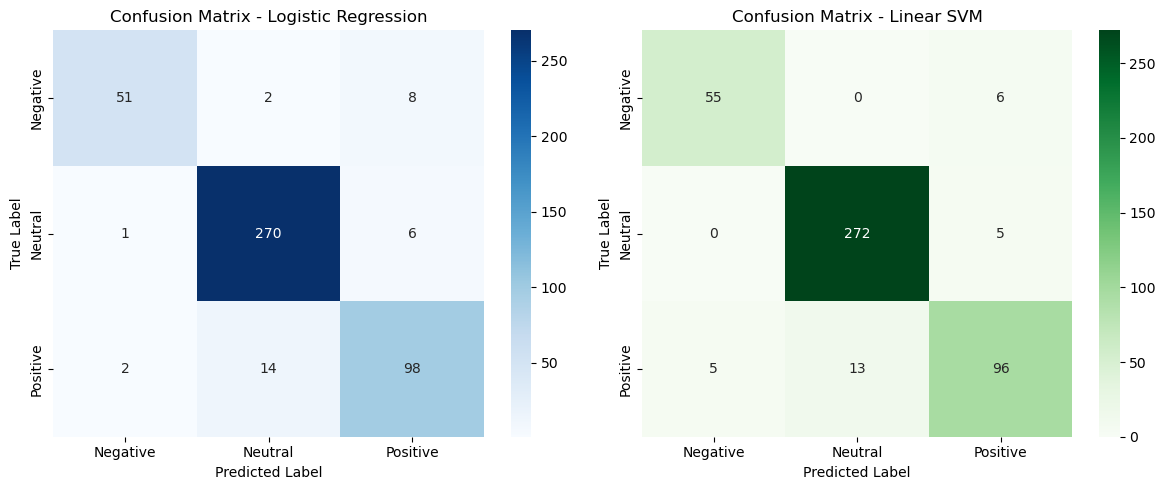

In [70]:
# ✅ Compute confusion matrices for both models
# This shows how many samples from each true class were predicted into each class
cm_lr = confusion_matrix(y_test, y_pred_lr_final, labels=['negative', 'neutral', 'positive'])
cm_svm = confusion_matrix(y_test, y_pred_svm_final, labels=['negative', 'neutral', 'positive'])

# ✅ Create a subplot figure with 1 row and 2 columns for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 🔵 Plot confusion matrix for Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Neutral', 'Positive'],  # Predicted labels
            yticklabels=['Negative', 'Neutral', 'Positive'])  # True labels
axes[0].set_title('Confusion Matrix - Logistic Regression')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# 🟢 Plot confusion matrix for Linear SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1].set_title('Confusion Matrix - Linear SVM')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# ✅ Adjust layout for clarity
plt.tight_layout()
plt.show()

# FinBERT Fine-Tuning and Evaluation


## Data Preparation for Transformer Input


In [71]:
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

# ✅ Map sentiment labels to numerical values for FinBERT training
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label_encoded'] = df['label'].map(label2id)

# ✅ Perform a stratified train/test split to maintain class distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# ✅ Convert the train/test DataFrames into HuggingFace Dataset objects
# Rename columns to match expected format for FinBERT: 'text' and 'label'
train_dataset = Dataset.from_pandas(
    train_df[['finbert_sentence', 'label_encoded']].rename(columns={'finbert_sentence': 'text', 'label_encoded': 'label'})
)
test_dataset = Dataset.from_pandas(
    test_df[['finbert_sentence', 'label_encoded']].rename(columns={'finbert_sentence': 'text', 'label_encoded': 'label'})
)

## Tokenization


In [72]:
from transformers import AutoTokenizer

# ✅ Load the pre-trained FinBERT tokenizer from Hugging Face
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Define a tokenization function for batched input
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# ✅ Apply tokenization to training and test datasets
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# ✅ Set the format of datasets to PyTorch tensors for compatibility with the Trainer
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1807 [00:00<?, ? examples/s]

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

## FinBERT Model Setup


In [73]:
from transformers import AutoModelForSequenceClassification

# ✅ Load the FinBERT model with a classification head for 3 sentiment classes
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,           # Use the pretrained FinBERT model
    num_labels=3,         # Number of output classes (negative, neutral, positive)
    id2label=id2label,    # Map from class index to label name
    label2id=label2id     # Map from label name to class index
)

## Training Configuration

In [74]:
from transformers import TrainingArguments

# ✅ Define training configuration for the HuggingFace Trainer
training_args = TrainingArguments(
    output_dir="./finbert_results",         # Directory to save model checkpoints and results
    eval_strategy="epoch",                  # Run evaluation at the end of each epoch
    save_strategy="epoch",                  # Save model at the end of each epoch
    logging_strategy="epoch",               # Log training metrics at the end of each epoch
    save_total_limit=2,                     # Keep only the last 2 saved models to save disk space
    load_best_model_at_end=True,            # After training, automatically load the best model
    metric_for_best_model="f1",             # Use F1 score (macro) to determine the best model
    num_train_epochs=5,                     # Number of epochs to train 
    per_device_train_batch_size=16,         # Batch size for training on each device (GPU/CPU)
    per_device_eval_batch_size=16,          # Batch size for evaluation on each device
    learning_rate=2e-5,                     # Learning rate for the optimizer
    weight_decay=0.01,                      # Weight decay for regularization
    logging_dir="./finbert_logs",           # Directory to store training logs
    report_to="none"                        # Disable integration with experiment tracking tools (e.g., WandB)
)

## Trainer Setup and Fine-Tuning


In [75]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ✅ Custom metric function to compute standard classification metrics
def compute_metrics(pred):
    labels = pred.label_ids                      # True labels
    preds = pred.predictions.argmax(-1)          # Predicted labels (choose class with highest logit)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)          # Accuracy calculation
    return {
        'accuracy': acc,                         # Return dictionary of metrics
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# ✅ Initialize HuggingFace Trainer with model, data, tokenizer, and evaluation config
trainer = Trainer(
    model=model,                                 # The FinBERT model
    args=training_args,                          # Training configuration defined earlier
    train_dataset=train_dataset,                 # Training set
    eval_dataset=test_dataset,                   # Evaluation (validation) set
    tokenizer=tokenizer,                         # Tokenizer for decoding input/output if needed
    compute_metrics=compute_metrics              # Custom metrics function
)

# ✅ Start training loop (this will also evaluate after each epoch based on training_args)
trainer.train()

C:\Users\elias\AppData\Local\Temp\ipykernel_22992\1056906606.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.593200,0.184239,0.929204,0.890881,0.878102,0.914297
2,0.092600,0.090948,0.977876,0.967695,0.963999,0.971742
3,0.038200,0.079434,0.980088,0.969688,0.966657,0.972945
4,0.021100,0.101817,0.973451,0.963738,0.958813,0.969335
5,0.014000,0.090311,0.977876,0.967695,0.963999,0.971742


TrainOutput(global_step=565, training_loss=0.15180766814577895, metrics={'train_runtime': 8441.3442, 'train_samples_per_second': 1.07, 'train_steps_per_second': 0.067, 'total_flos': 594307432293120.0, 'train_loss': 0.15180766814577895, 'epoch': 5.0})

## Final Evaluation on Test Set

In [76]:
# ✅ Evaluate the best version of the FinBERT model on the test set
results = trainer.evaluate()  # This automatically loads the best checkpoint (as specified in TrainingArguments)
print(results)  # ✅ Print the evaluation metrics (accuracy, precision, recall, F1 from compute_metrics function)

{'eval_loss': 0.07943373918533325, 'eval_accuracy': 0.9800884955752213, 'eval_f1': 0.9696880620792435, 'eval_precision': 0.9666574048346762, 'eval_recall': 0.9729451264230095, 'eval_runtime': 97.3902, 'eval_samples_per_second': 4.641, 'eval_steps_per_second': 0.298, 'epoch': 5.0}


## Test Set Confusion Matrix and Summary Metrics

              precision    recall  f1-score   support

    Negative     0.9508    0.9508    0.9508        61
     Neutral     1.0000    0.9856    0.9927       277
    Positive     0.9492    0.9825    0.9655       114

    accuracy                         0.9801       452
   macro avg     0.9667    0.9729    0.9697       452
weighted avg     0.9805    0.9801    0.9802       452



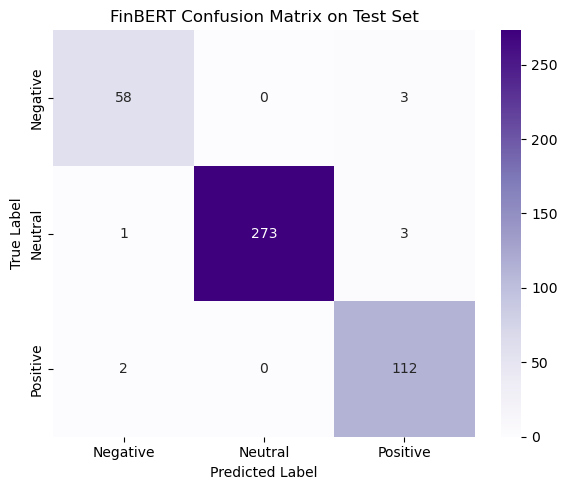

In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 🔍 Get predictions from the trained FinBERT model
predictions = trainer.predict(test_dataset)

# Extract predicted labels (argmax over logits) and true labels
y_pred_finbert = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# 📊 Print a detailed classification report (precision, recall, F1) for each class
print(classification_report(y_true, y_pred_finbert, target_names=['Negative', 'Neutral', 'Positive'], digits=4))

# 📉 Generate a confusion matrix for FinBERT predictions
cm = confusion_matrix(y_true, y_pred_finbert, labels=[0,1,2])

# 📈 Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('FinBERT Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Model Performance Summary

In [78]:
# ✅ Create a one-row DataFrame to store FinBERT’s evaluation results
finbert_results = pd.DataFrame({
    "Model": ["FinBERT"],
    "Accuracy": [accuracy_score(y_true, y_pred_finbert)],
    "Precision (Macro)": [precision_score(y_true, y_pred_finbert, average='macro')],
    "Recall (Macro)": [recall_score(y_true, y_pred_finbert, average='macro')],
    "F1-Score (Macro)": [f1_score(y_true, y_pred_finbert, average='macro')]
})

# ✅ Round all metric values to 4 decimal places for clean formatting
finbert_results[['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']] = \
    finbert_results[['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']].round(4)

# ✅ Combine FinBERT results with previously stored classical model results
final_results_df = pd.concat([final_results_df, finbert_results], ignore_index=True)

In [79]:
# Display updated table
final_results_df

,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Logistic Regression,0.9270,0.9212,0.8901,0.9045
1,Linear SVM,0.9358,0.9227,0.9086,0.9153
2,FinBERT,0.9801,0.9667,0.9729,0.9697


## Confusion Matrices Side-by-Side

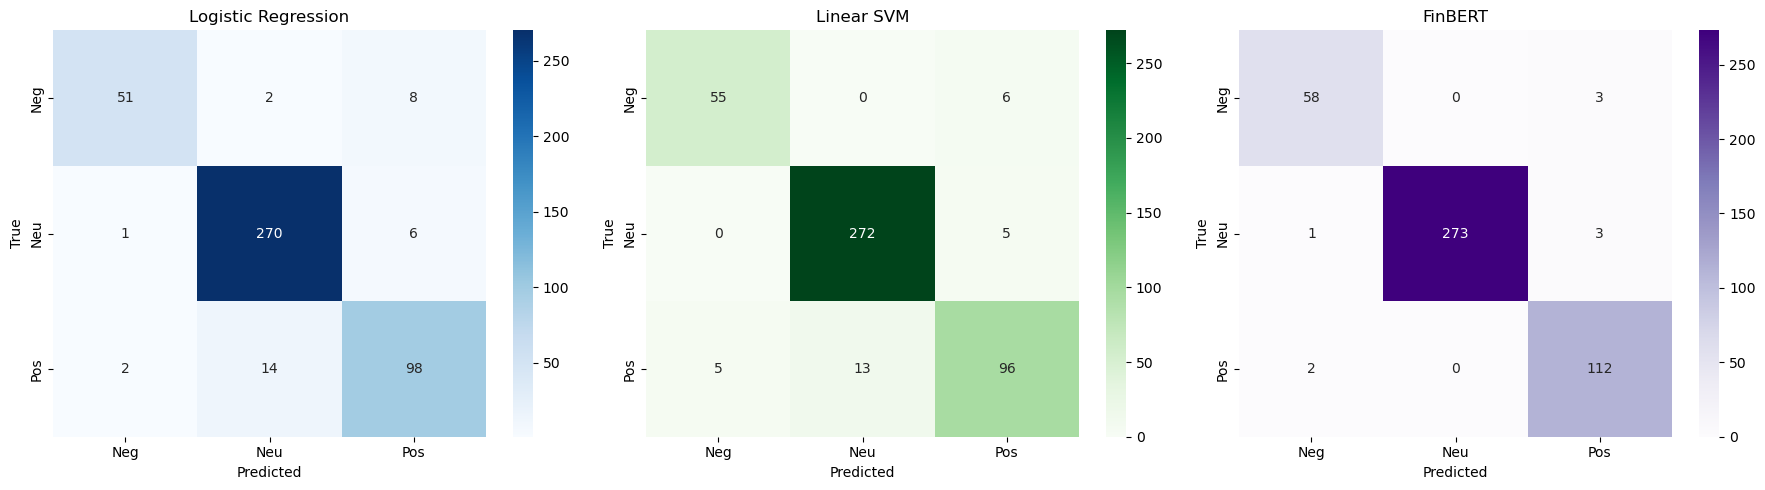

In [80]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix for Logistic Regression using string labels
cm_lr = confusion_matrix(y_test, y_pred_lr_final, labels=['negative', 'neutral', 'positive'])

# Compute confusion matrix for Linear SVM using string labels
cm_svm = confusion_matrix(y_test, y_pred_svm_final, labels=['negative', 'neutral', 'positive'])

# Compute confusion matrix for FinBERT using encoded integer labels (0=negative, 1=neutral, 2=positive)
cm_finbert = confusion_matrix(y_true, y_pred_finbert, labels=[0, 1, 2])

# Setup 1x3 subplot layout for visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Logistic Regression confusion matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
axes[0].set_title("Logistic Regression")

# Plot Linear SVM confusion matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
axes[1].set_title("Linear SVM")

# Plot FinBERT confusion matrix
sns.heatmap(cm_finbert, annot=True, fmt='d', cmap='Purples', ax=axes[2],
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
axes[2].set_title("FinBERT")

# Set common axis labels for all subplots
for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Misclassification Counts

C:\Users\elias\AppData\Local\Temp\ipykernel_22992\883031417.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=misclass_df, x="Model", y="Misclassified Samples", palette="pastel")


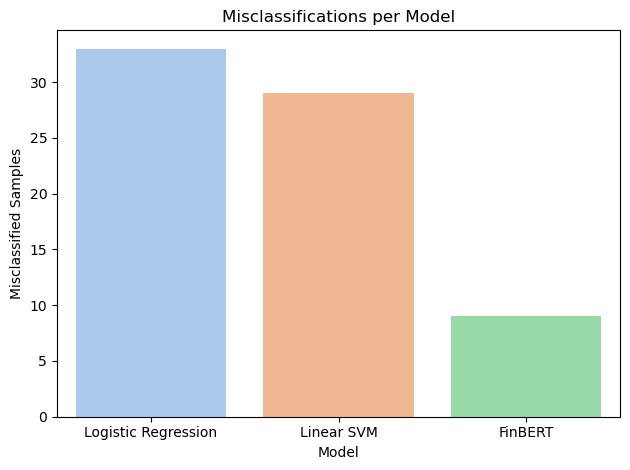

In [81]:
import pandas as pd

# Create a DataFrame that includes true labels and predictions from all models
comparison_df = pd.DataFrame({
    'True Label': y_test,                 # Ground truth labels for classical models (string labels)
    'True Label FB': y_true,             # Ground truth labels for FinBERT (integer-encoded)
    'LR Prediction': y_pred_lr_final,    # Predictions from Logistic Regression
    'SVM Prediction': y_pred_svm_final,  # Predictions from Linear SVM
    'FinBERT Prediction': y_pred_finbert # Predictions from FinBERT (integer-encoded)
})

# Mark misclassifications by comparing predictions with the corresponding true labels
comparison_df['Misclassified by LR'] = comparison_df['True Label'] != comparison_df['LR Prediction']
comparison_df['Misclassified by SVM'] = comparison_df['True Label'] != comparison_df['SVM Prediction']
comparison_df['Misclassified by FinBERT'] = comparison_df['True Label FB'] != comparison_df['FinBERT Prediction']

# Count the number of misclassified samples for each model
misclass_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVM', 'FinBERT'],
    'Misclassified Samples': [
        comparison_df['Misclassified by LR'].sum(),
        comparison_df['Misclassified by SVM'].sum(),
        comparison_df['Misclassified by FinBERT'].sum()
    ]
})

# Plot a bar chart comparing the number of misclassified samples per model
sns.barplot(data=misclass_df, x="Model", y="Misclassified Samples", palette="pastel")
plt.title("Misclassifications per Model")
plt.tight_layout()
plt.show()

## Misclassified Examples (Qualitative Insight)

In [130]:
# ✅ Recover original test sentences (raw + clean) from the same split
from sklearn.model_selection import train_test_split

# This split must match your earlier train/test split to ensure sentence alignment
X_all_text = df['sentence'].values        # Original raw sentences (as they appeared before preprocessing)
X_clean_text = df['clean_sentence'].values  # Corresponding cleaned/preprocessed versions of the same sentences

# Match the test split used earlier (20% test set, stratified by label, same seed for reproducibility)
# This is done twice—once for raw text, once for cleaned text—so that the indexes align with model predictions
_, X_test_sentences_raw = train_test_split(X_all_text, test_size=0.2, stratify=y, random_state=42)
_, X_test_sentences_clean = train_test_split(X_clean_text, test_size=0.2, stratify=y, random_state=42)

In [131]:
# Decode FinBERT predictions from IDs to original labels
y_pred_finbert_labels = [id2label[p] for p in y_pred_finbert]

In [132]:
# ✅ Create a comparison DataFrame to analyze model predictions side by side
comparison_df = pd.DataFrame({
    "Raw Sentence": X_test_sentences_raw,            # Original test sentence (before preprocessing)
    "Cleaned Sentence": X_test_sentences_clean,      # Preprocessed version used for classical models
    "True Label": y_test,                            # Ground truth sentiment label (string)
    "LogReg Prediction": y_pred_lr_final,            # Prediction from Logistic Regression model
    "SVM Prediction": y_pred_svm_final,              # Prediction from Linear SVM model
    "FinBERT Prediction": y_pred_finbert_labels      # Prediction from FinBERT, converted back to string
})

# ✅ Add Boolean flags to indicate whether each model made an error on each sample
comparison_df["Misclassified by LR"] = comparison_df["LogReg Prediction"] != comparison_df["True Label"]
comparison_df["Misclassified by SVM"] = comparison_df["SVM Prediction"] != comparison_df["True Label"]
comparison_df["Misclassified by FinBERT"] = comparison_df["FinBERT Prediction"] != comparison_df["True Label"]

### Misclassified by all models

In [141]:
from IPython.display import display, HTML

# ✅ Filter rows where all three models made an incorrect prediction
all_wrong_df = comparison_df[
    (comparison_df["Misclassified by LR"]) &
    (comparison_df["Misclassified by SVM"]) &
    (comparison_df["Misclassified by FinBERT"])
]

# ✅ Print how many such examples exist
print(f"❌ Examples misclassified by all models: {len(all_wrong_df)}")

# ✅ Randomly select up to 5 examples from the misclassified ones and display them
# - Only show raw and cleaned versions of the sentence
# - Use .style to improve readability with wrapped text and wider columns
styled = all_wrong_df[['Raw Sentence', 'Cleaned Sentence']].sample(min(5, len(all_wrong_df)), random_state=1).style \
    .set_properties(**{'white-space': 'pre-wrap', 'width': '300px'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]) \
    .set_caption("💥 Examples Misclassified by All Models")

# ✅ Display the styled DataFrame in a nicely formatted HTML table
display(styled)

❌ Examples misclassified by all models: 4


,Raw Sentence,Cleaned Sentence
1857,"In the third quarter of fiscal 2008 Efore swung to a net loss of EUR 400,000 versus a net profit of EUR 200,000 for the corresponding period of fiscal 2007 .",in the third quarter of fiscal efore swung to a net loss of eur versus a net profit of eur for the corresponding period of fiscal
345,Unit costs for flight operations fell by 6.4 percent .,unit cost for flight operation fell by percent
480,These moderate but significant changes resulted in a significant 24-32 % reduction in the estimated CVD risk .,these moderate but significant change resulted in a significant reduction in the estimated cvd risk
371,"Finnish power supply solutions and systems provider Efore Oyj said its net loss widened to 3.2 mln euro $ 4.2 mln for the first quarter of fiscal 2006-2007 ending October 31 , 2007 from 900,000 euro $ 1.2 mln for the same period of fiscal 2005-06 .",finnish power supply solution and system provider efore oyj said it net loss widened to mln euro mln for the first quarter of fiscal ending october from euro mln for the same period of fiscal


### Miscalissified only by Classical models

In [142]:
from IPython.display import display

# ✅ Filter rows where FinBERT was correct but both classical models were wrong
finbert_only_correct = comparison_df[
    (~comparison_df["Misclassified by FinBERT"]) &  # FinBERT predicted correctly
    (comparison_df["Misclassified by LR"]) &         # Logistic Regression failed
    (comparison_df["Misclassified by SVM"])          # SVM failed
]

# ✅ Print the count of such instances
print(f"✅ FinBERT succeeded where others failed: {len(finbert_only_correct)}")

# ✅ Sample up to 5 examples and apply formatting for readability
# - Only display raw and cleaned sentence text
# - Use .style to wrap long text and improve column width
styled_finbert = finbert_only_correct[['Raw Sentence', 'Cleaned Sentence']].sample(
    min(5, len(finbert_only_correct)), random_state=2
).style \
.set_properties(**{'white-space': 'pre-wrap', 'width': '300px'}) \
.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]) \
.set_caption("✅ FinBERT Correct While Classical Models Failed")

# ✅ Display the styled table
display(styled_finbert)

✅ FinBERT succeeded where others failed: 20


,Raw Sentence,Cleaned Sentence
1894,"In October , UPM reported a third-quarter net loss of euro86 million $ 110 million compared with a net profit of euro120 million in 2007 .",in october upm reported a thirdquarter net loss of euro million million compared with a net profit of euro million in
797,Both the net sales and operating profit were record high in the company 's history .,both the net sale and operating profit were record high in the company s history
2140,"Insurer Axa ( PAR : CS ) slid by 5.35 % to EUR 14.15 , after Citigroup and ING slashed their targets on the stock .",insurer axa par c slid by to eur after citigroup and ing slashed their target on the stock
420,"According to Atria 's President and CEO Matti Tikkakoski , the company 's Swedish operations significantly improved in the first quarter .",according to atrium s president and ceo matti tikkakoski the company s swedish operation significantly improved in the first quarter
802,"India 's trade with Russia currently stands at four billion dollars , growing 9.6 per cent in fiscal 2007 .",india s trade with russia currently stand at four billion dollar growing per cent in fiscal


### Misclassified only by FinBERT model

In [143]:
from IPython.display import display

# ✅ Filter: Keep only rows where:
# - FinBERT prediction is incorrect
# - Both Logistic Regression and SVM predicted correctly
comparison_df_classical_correct = comparison_df[
    (comparison_df["Misclassified by FinBERT"]) &     # FinBERT failed
    (~comparison_df["Misclassified by LR"]) &         # LR succeeded
    (~comparison_df["Misclassified by SVM"])          # SVM succeeded
]

# ✅ Print how many such examples exist
print(f"🔍 Classical models succeeded, FinBERT failed: {len(comparison_df_classical_correct)}")

# ✅ Select and display a sample of 5 (or fewer) such cases
# Columns shown: raw sentence, true label, and FinBERT's incorrect prediction
styled_classical = comparison_df_classical_correct[['Raw Sentence', 'True Label', 'FinBERT Prediction']].sample(
    min(5, len(comparison_df_classical_correct)), random_state=3
).style \
.set_properties(**{'white-space': 'pre-wrap', 'width': '300px'}) \
.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]) \
.set_caption("🔍 FinBERT Misclassified But Classical Models Were Correct")

# ✅ Display the styled sample
display(styled_classical)

🔍 Classical models succeeded, FinBERT failed: 5


,Raw Sentence,True Label,FinBERT Prediction
372,"ADP News - Apr 22 , 2009 - Finnish business information systems developer Solteq Oyj HEL : STQ1V said today its net loss widened to EUR 189,000 USD 245,000 for the first quarter of 2009 from EUR 10,000 for the same peri",negative,positive
1921,"The company reported a profit of 800,000 euro ($ 1.2 mln)on the sale of its Varesvuo Partners sub-group and a loss of 400,000 euro $ 623,000 caused by the sale of its program production subsidiary Oy Filmiteollisuus Fine Ab .",neutral,negative
1308,Nordea was the cheapest also for a couple in their 30s with debt .,neutral,positive
1642,In 2008 Stockmann earned 3.398 million lats in profit on 48.012 million lats in turnover .,neutral,positive
1579,`` These developments partly reflect the government 's higher activity in the field of dividend policy . '',neutral,positive


## Feature Importance from Logistic Regression Model (Most Interpretable)

In [147]:
# ✅ Use the TF-IDF vectorizer already fitted on the full dataset earlier
# This provides access to the vocabulary (i.e., feature names) used during training
feature_names = tfidf_vectorizer.get_feature_names_out()

# ✅ Get the learned coefficients from the trained logistic regression model
# Shape: (n_classes, n_features)
coefs = final_lr_model.coef_

# ✅ Loop through each class to analyze the top influential features
for i, class_label in enumerate(final_lr_model.classes_):
    
    # 🔼 Get indices of top 10 positive coefficients (strongest predictors FOR this class)
    top_idx = np.argsort(coefs[i])[-10:]
    
    # 🔽 Get indices of 10 lowest coefficients (strongest predictors AGAINST this class)
    bottom_idx = np.argsort(coefs[i])[:10]
    
    # 🟩 Map feature indices back to actual token strings (from TF-IDF vocabulary)
    top_features = [feature_names[j] for j in top_idx]
    bottom_features = [feature_names[j] for j in bottom_idx]

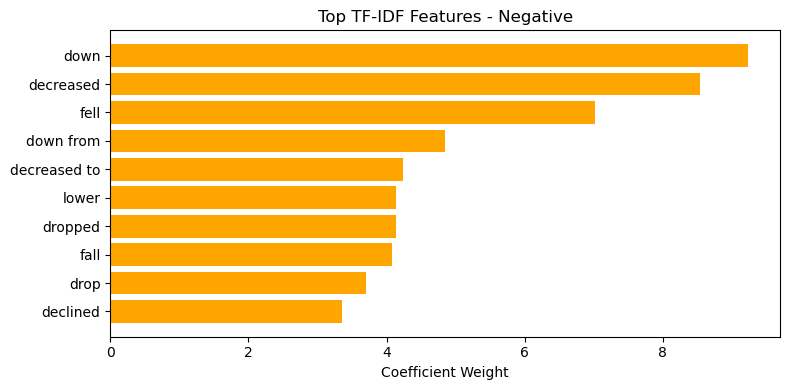

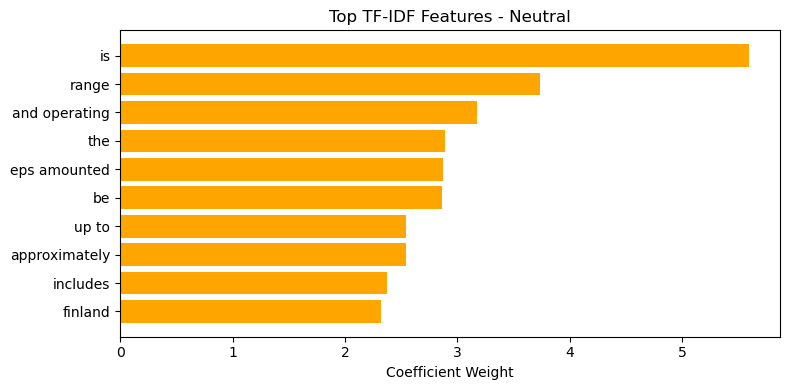

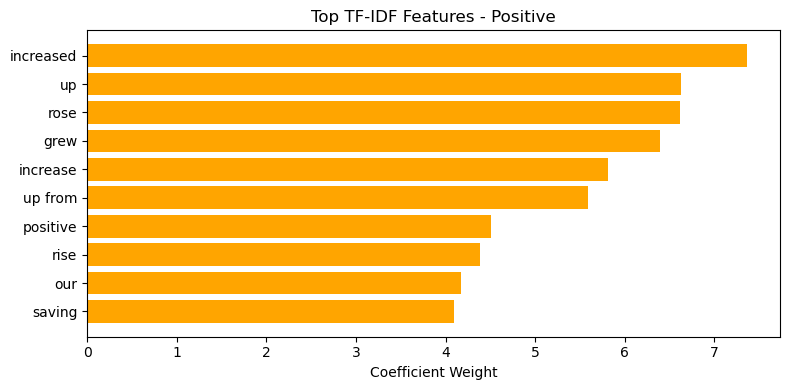

In [153]:
import matplotlib.pyplot as plt

# ✅ Loop over each sentiment class index and label
for i, class_label in enumerate(['negative', 'neutral', 'positive']):
    
    # 🔼 Find indices of top 10 most positive coefficients for this class
    top_idx = np.argsort(coefs[i])[-10:]
    
    # 🟩 Map the indices to their corresponding feature names
    top_features = [feature_names[j] for j in top_idx]
    
    # 📊 Get the actual coefficient values for plotting
    top_weights = coefs[i][top_idx]

    # 🎨 Create a horizontal bar plot for top features
    plt.figure(figsize=(8, 4))
    plt.barh(top_features, top_weights, color='orange')
    plt.title(f"Top TF-IDF Features - {class_label.capitalize()}")
    plt.xlabel("Coefficient Weight")
    plt.tight_layout()
    plt.show()